# Global mean Sea Surface Temperatures

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib.dates import DateFormatter
import platform
import os

from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

plt.rcParams['figure.figsize'] = (10, 4)

In [2]:
client = Client(n_workers=48, threads_per_worker=2, memory_limit='32GB')

#### Settings

In [3]:
year1=1982
year2=2023

In [4]:
#To compute de climatoloy
yearC1='1982'
yearC2='1992'

In [ ]:
HOME=os.environ['HOME']
USER=os.environ['USER']   

## Load data

In [4]:
if os.uname().nodename.lower().find('eemmmbp') != -1:
    base_file = HOME + '/Dropbox/Oceanografia/Data/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
elif os.uname().nodename.lower().find('rossby') != -1:
    base_file = '/data/shareddata/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
    dataDir   = HOME + '/Analisis/SSTGlobalAnalysis/data'

In [ ]:
files = [f'{base_file}.{year}.nc' for year in range(year1, year2+1)]
DS = xr.open_mfdataset(files,chunks={"lon": 36, "lat":18}, parallel=True)

In [ ]:
DS

## Seleccion Atlantico norte

In [6]:
titulo_short = 'NAtl'
titulo = 'NorthAtlantic'
sst = DS.sst.sel(lat=slice(0, 80))

basins = xr.open_dataset('./data/basins.nc')
basin_surf = basins.basin[0]

basin_surf_interp = basin_surf.interp_like(sst, method='nearest')
sst = sst.where((basin_surf_interp==1) | (basin_surf_interp==4) ,drop=True)

## Mean

>>>>> NorthAtlanticNAtl
    > Mean


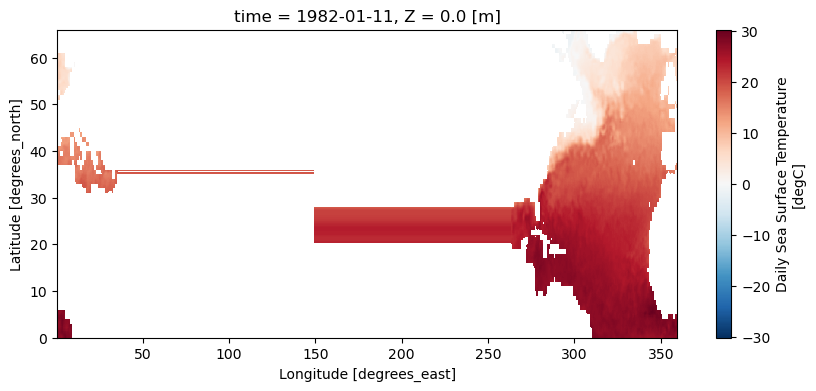

In [7]:
sst[10,:,:].plot()
print('>>>>> '+titulo+titulo_short)
print('    > Mean')

In [13]:
# Calculate global mean weigthtened
# For a rectangular grid the cosine of the latitude is proportional to the grid cell area.
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_weighted = sst.weighted(weights)
sst_wmean = sst_weighted.mean(("lon", "lat"),skipna=True).load()

## Seasonal cycle
Create seasonal climatology from 1982 to 1992 and the asociated anomaly

In [14]:
#Create monthly climatology
sst_clim = sst.sel(time=slice(yearC1,yearC2)).groupby('time.dayofyear').mean(dim='time').load();

In [15]:
#Create anomaly
sst_anom = sst.groupby('time.dayofyear') - sst_clim

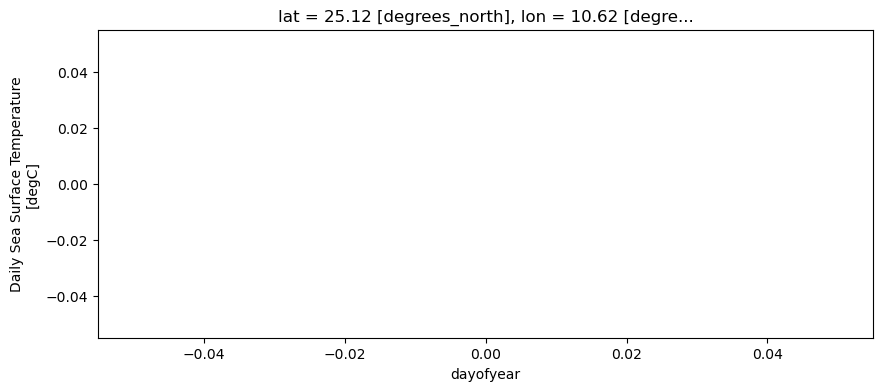

In [16]:
sst_clim[:,100,40].plot()

## Mean anomaly

In [17]:
# Calculate global mean weigthtened
# For a rectangular grid the cosine of the latitude is proportional to the grid cell area.
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_anom_weighted = sst_anom.weighted(weights)
sst_anom_wmean = sst_anom_weighted.mean(("lon", "lat"),skipna=True).load()

In [18]:
# smoothed versions
sst_wmean_rolling = sst_wmean.rolling(time=360,center=True).mean()
sst_anom_wmean_rolling = sst_anom_wmean.rolling(time=360,center=True).mean()

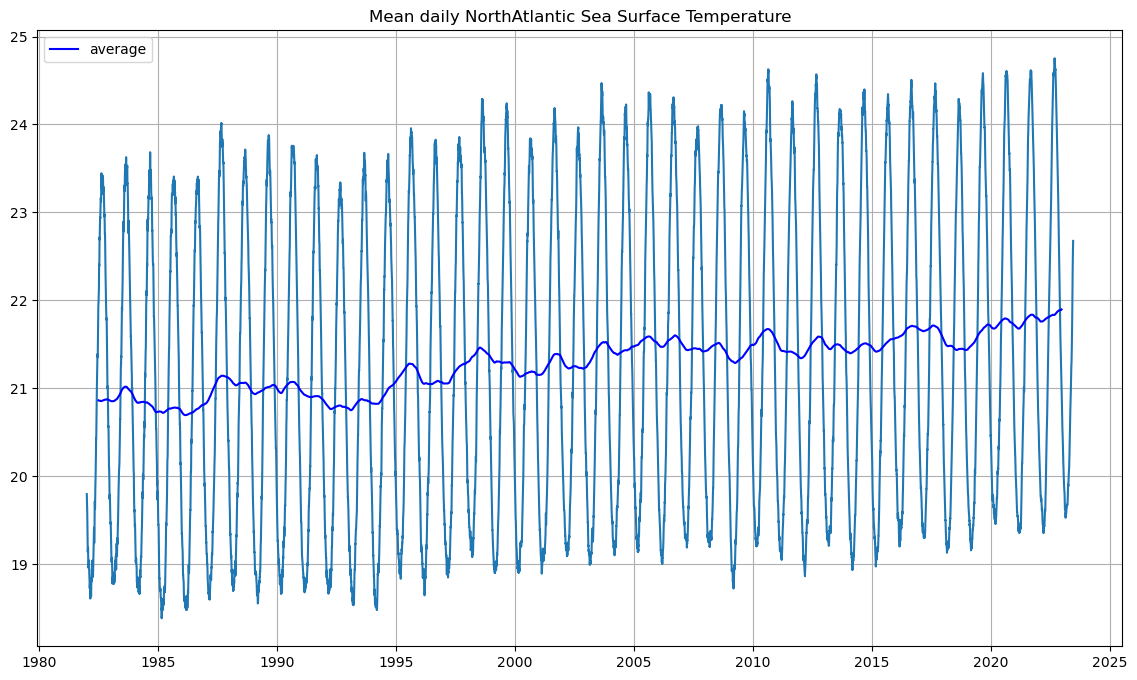

In [19]:
fig, ax = plt.subplots(1, 1 , figsize=(14,8))
ax.plot(sst_wmean.time,sst_wmean)
ax.plot(sst_wmean_rolling.time,sst_wmean_rolling,'-b',label='average')
ax.grid()
ax.legend()
ax.set_title('Mean daily '+titulo+' Sea Surface Temperature');

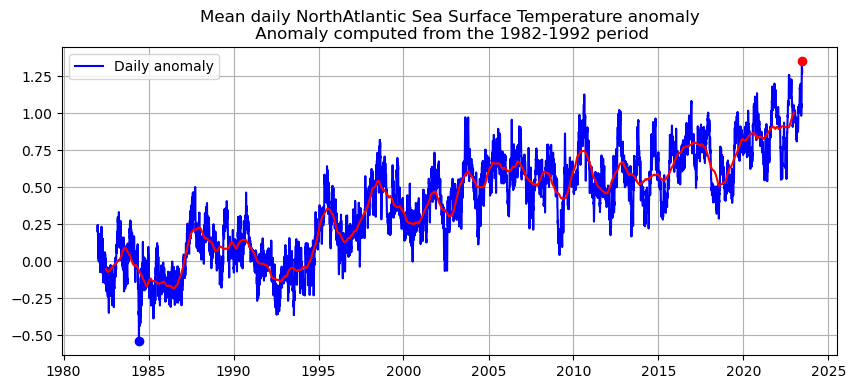

In [20]:
fig, ax = plt.subplots(1, 1 , figsize=(10,4))
ax.plot(sst_anom_wmean.time        ,sst_anom_wmean,'b',label='Daily anomaly')
ax.plot(sst_anom_wmean_rolling.time,sst_anom_wmean_rolling,'r')

ax.plot(sst_anom_wmean.time.isel(sst_anom_wmean.argmax(...)),
        sst_anom_wmean.isel(sst_anom_wmean.argmax(...)),'ro')
ax.plot(sst_anom_wmean.time.isel(sst_anom_wmean.argmin(...)),
        sst_anom_wmean.isel(sst_anom_wmean.argmin(...)),'bo')

ax.grid()
ax.legend()
ax.set_title('Mean daily '+titulo+' Sea Surface Temperature anomaly\n Anomaly computed from the 1982-1992 period');

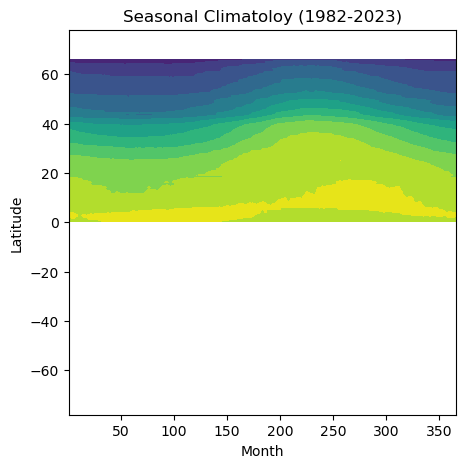

In [21]:
fig, ax = plt.subplots(1, 1 , figsize=(5,5))
ax.contourf(sst_clim.mean(dim='lon').dayofyear,
                 sst_clim.mean(dim='lon').lat,
                 sst_clim.mean(dim='lon').transpose(),levels=12, vmin=-2, vmax=30)
ax.set_ylim(-78,78)
ax.grid()
ax.set_title('Seasonal Climatoloy (' + str(year1) + '-' + str(year2) + ')')
ax.set_ylabel('Latitude') 
ax.set_xlabel('Month')
ax.grid()

In [22]:
sst_anom_LD=sst_anom[-1,:,:]
sst_anom_LD

<xarray.DataArray 'sst' (lat: 264, lon: 528)>
dask.array<getitem, shape=(264, 528), dtype=float32, chunksize=(264, 528), chunktype=numpy.ndarray>
Coordinates:
    time       datetime64[ns] 2023-06-15
  * lat        (lat) float32 0.125 0.375 0.625 0.875 ... 65.12 65.38 65.62 65.88
  * lon        (lon) float32 0.625 0.875 1.125 1.375 ... 358.6 358.9 359.1 359.4
    Z          float32 0.0
    dayofyear  int64 166

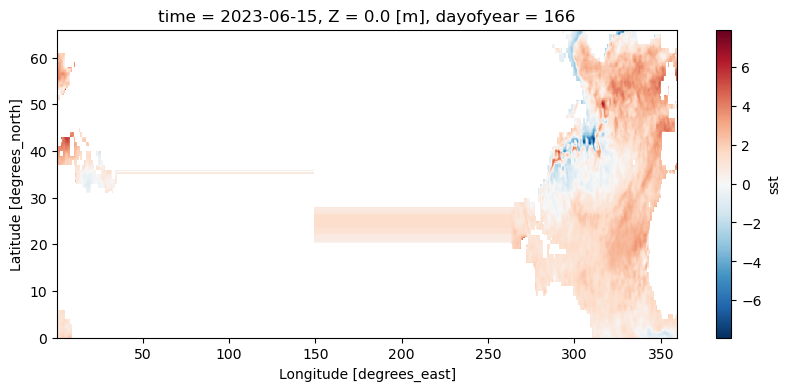

In [23]:
sst_anom_LD.plot()

In [24]:
sst_anom_LD.to_netcdf(dataDir + '/sstLD_anom_'+titulo_short+'.nc',mode='w')
sst_wmean.to_netcdf(dataDir + '/sstd_mean_'+titulo_short+'.nc',mode='w')
sst_anom_wmean.to_netcdf(dataDir + '/sstd_anom_mean_'+titulo_short+'.nc',mode='w')
#sst_clim.to_netcdf(dataDir + '/Psstd_clim_'+titulo_short+'.nc',mode='w')

In [25]:
sst_anom_LD.to_netcdf('./data/sstLD_anom_'+titulo_short+'.nc',mode='w')

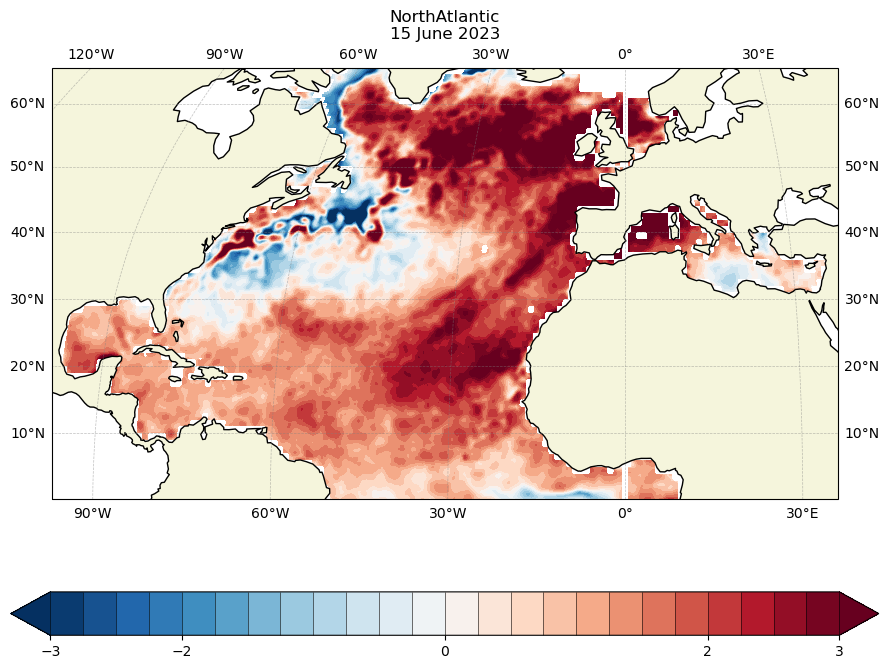

In [26]:
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

land = cartopy.feature.NaturalEarthFeature('physical', 
                'land', edgecolor='k', scale = '110m' ,
                facecolor=cfeature.COLORS['land'])

ax.add_feature(land, facecolor='beige')
ax.add_feature(cfeature.LAND)
    
cm=ax.contourf(sst_anom_LD.lon,sst_anom_LD.lat,sst_anom_LD, levels=np.arange(-3,3.1,0.25), 
               transform=ccrs.PlateCarree(),
               cmap = plt.cm.RdBu.reversed(),
               vmin = -3,vmax = 3,extend='both')

#ax.contour(sst.lon,sst.lat,sst, levels=[2,3], colors='k',
#               transform=ccrs.PlateCarree())

cbar=fig.colorbar(cm,ax=ax, location='bottom',
                  shrink=.8, ticks=[-3,-2,0,2,3], 
                  drawedges=True)

ax.gridlines(draw_labels=True, linewidth=.5, 
             color='gray', alpha=0.5, linestyle='--')

ax.set_title(titulo + '\n' +
             sst_anom_LD.time.dt.strftime("%d %B %Y").values);